In [24]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

<ipython-input-25-f05cc5a27e54>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Attrition'], palette="viridis")


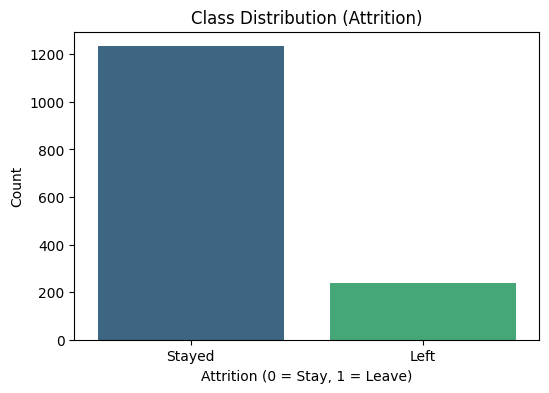

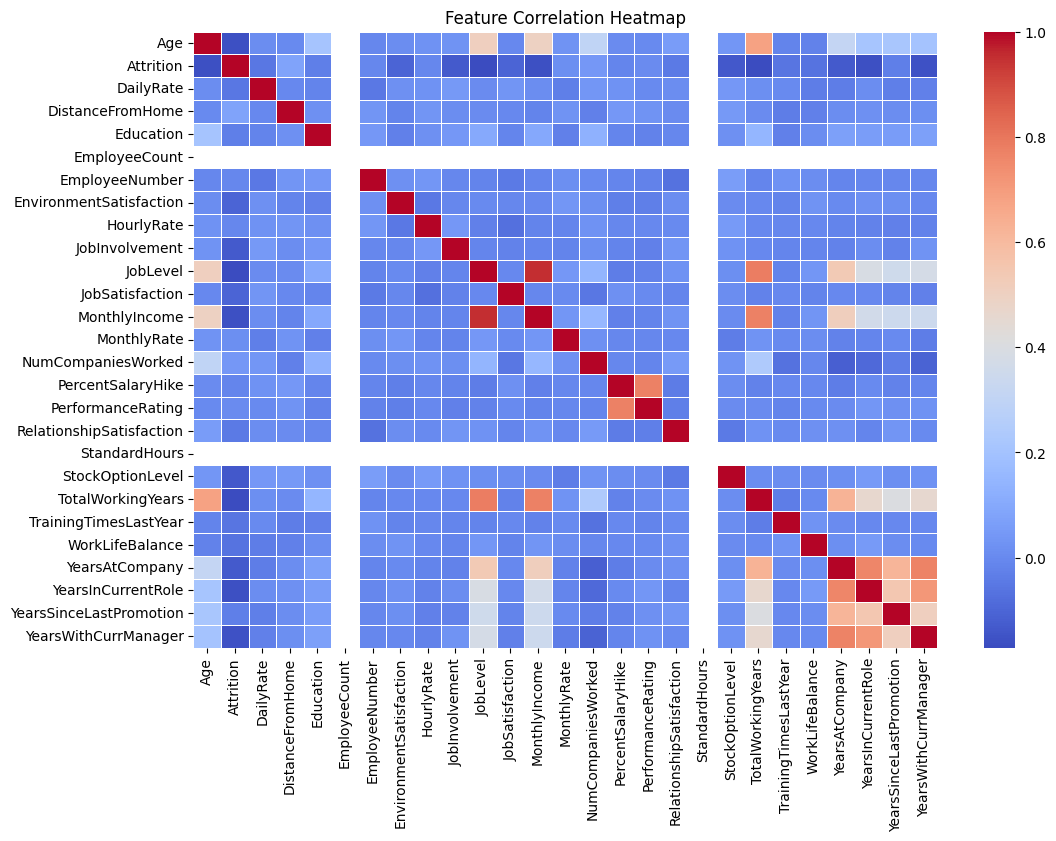

In [25]:
#VIZUALIZACIJA PODATAKA

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df['Attrition'], palette="viridis")
plt.title("Class Distribution (Attrition)")
plt.xlabel("Attrition (0 = Stay, 1 = Leave)")
plt.ylabel("Count")
plt.xticks([0, 1], ["Stayed", "Left"])
plt.show()

# feature correaltion heatmap
plt.figure(figsize=(12, 8))
mat = df.corr(numeric_only=True)
sns.heatmap(mat, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


In [26]:
# Load-ovanje data seta
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

# Izbacujemo kolone koje nisu relevantne
df.drop(columns=['EmployeeCount', 'EmployeeNumber', 'StandardHours', 'Over18'], inplace=True)

# Pretvaranje target promenljive
target = 'Attrition'  # Da = 1, Ne = 0
df[target] = df[target].map({'Yes': 1, 'No': 0})

# Identifikacija kategorickih karakteristika
categoricalFeatures = df.select_dtypes(include=['object']).columns.tolist()

# Primena one-hot encoding-a
df = pd.get_dummies(df, columns=categoricalFeatures, drop_first=True)

# normalizacija numerickih podataka
numericalFeatures = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numericalFeatures.remove(target)
df[numericalFeatures] = MinMaxScaler().fit_transform(df[numericalFeatures])

# Uveravamo se da su svi podaci numericki
X = df.drop(columns=[target])
y = df[target]

# uklanjamo neravnotežu klase (ponderisan gubitak - weighted loss)
class_counts = Counter(y)
total_samples = len(y)
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
weights = torch.tensor([class_weights[label] for label in y], dtype=torch.float)

# Podela podataka za treniranje i testiranje
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, test_size=0.2, random_state=42, stratify=y)

# Konvertovanje u pytorch tensore
X_train_tensor = torch.tensor(X_train.to_numpy(dtype=np.float))
y_train_tensor = torch.tensor(y_train.to_numpy(dtype=np.float)).unsqueeze(1)
X_test_tensor = torch.tensor(X_test.to_numpy(dtype=np.float))
y_test_tensor = torch.tensor(y_test.to_numpy(dtype=np.float)).unsqueeze(1)
weights_train_tensor = torch.tensor(weights_train.numpy()).unsqueeze(1)


In [27]:
#definisanje modela

class EmployeeRetentionANN(nn.Module):
    def __init__(self, input_size):
        super(EmployeeRetentionANN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.batch_norm3 = nn.BatchNorm1d(32)
        self.dropout = nn.Dropout(0.25)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.batch_norm1(self.relu(self.fc1(x)))
        x = self.dropout(x)
        x = self.batch_norm2(self.relu(self.fc2(x)))
        x = self.dropout(x)
        x = self.batch_norm3(self.relu(self.fc3(x)))
        x = self.sigmoid(self.fc4(x))
        return x

# inicijalizacija modela
model = EmployeeRetentionANN(X_train.shape[1])

# Weighted loss fun (funkcija ponderisanog gubitka)
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=1.5):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce_loss = nn.BCELoss()(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss

class_weights_tensor = torch.tensor([1.0, 1.5], dtype=torch.float).to(y_train_tensor.device)
criterion = nn.BCELoss(weight=class_weights_tensor.mean())
optimizer = optim.Adam(model.parameters(), lr=0.0015)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.97)

In [28]:
# petlja za trening/učenje
losses = []

def train_model(model, X_train, y_train, epochs=50):
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')


In [29]:
# treniranje modela
train_model(model, X_train_tensor, y_train_tensor, epochs=50)

# predvidjanja sa nižim pragom
y_pred_tensor = model(X_test_tensor)
from sklearn.metrics import precision_recall_curve

y_prob = y_pred_tensor.detach().numpy()
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
if len(thresholds) > 0:
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    optimal_idx = f1_scores.argmax()
    best_threshold = thresholds[min(optimal_idx, len(thresholds) - 1)]
else:
    best_threshold = 0.5
best_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else thresholds[-1]
y_pred = (y_pred_tensor.detach().numpy() > best_threshold).astype(int)

# evaluacija modela
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Epoch 0, Loss: 0.9542
Epoch 10, Loss: 0.7900
Epoch 20, Loss: 0.6705
Epoch 30, Loss: 0.5666
Epoch 40, Loss: 0.4502
Accuracy: 0.8571
Precision: 0.5676
Recall: 0.4468


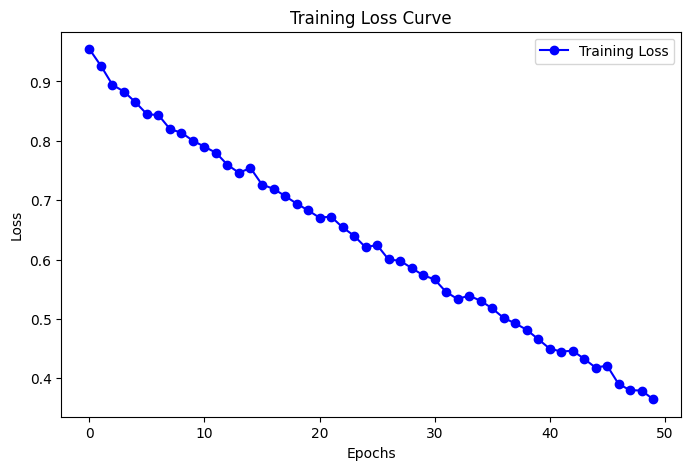

In [30]:
epochs = np.arange(0, 50, 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, losses, marker='o', linestyle='-', color='b', label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()



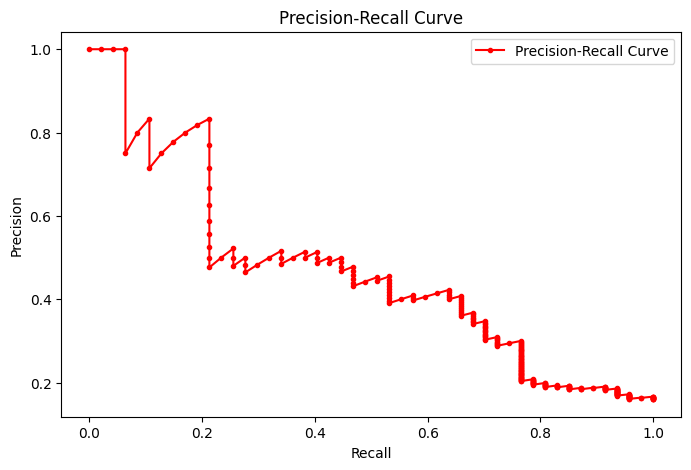

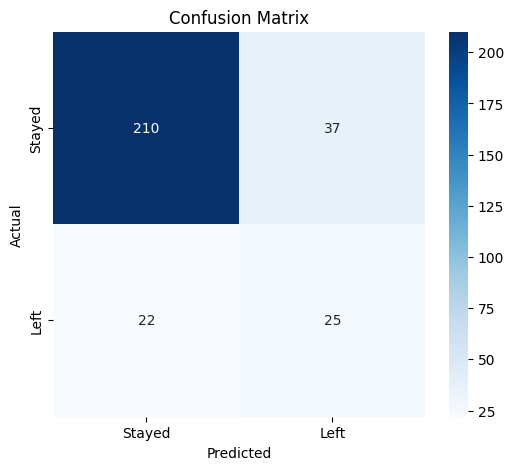

In [34]:
from sklearn.metrics import precision_recall_curve, confusion_matrix

y_test = y_test_tensor.numpy().flatten()
y_pred_prob = model(X_test_tensor).detach().numpy().flatten()

precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 5))
plt.plot(recall_vals, precision_vals, marker='.', color='red', label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

y_pred = (y_pred_prob > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Stayed", "Left"], yticklabels=["Stayed", "Left"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Decision Tree Accuracy: 0.8333
Decision Tree Precision: 0.4444
Decision Tree Recall: 0.1702


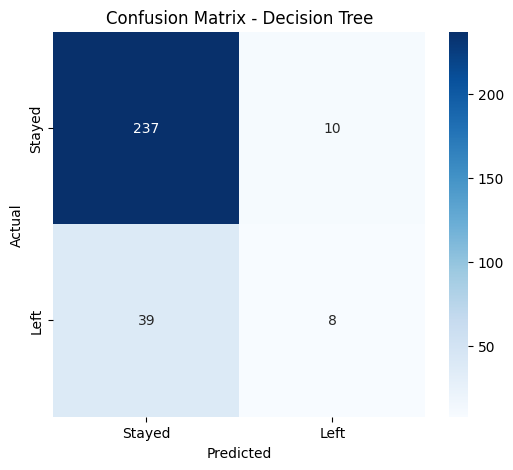

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix


df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

df.drop(columns=['EmployeeCount', 'EmployeeNumber', 'StandardHours', 'Over18'], inplace=True)

categoricalFeatures = df.select_dtypes(include=['object']).columns.tolist()

df = pd.get_dummies(df, columns=categoricalFeatures, drop_first=True)

numericalFeatures = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numericalFeatures.remove('Attrition')
df[numericalFeatures] = MinMaxScaler().fit_transform(df[numericalFeatures])

X = df.drop(columns=['Attrition'])
y = df['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)

dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_precision = precision_score(y_test, y_pred_dt)
dt_recall = recall_score(y_test, y_pred_dt)

print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")
print(f"Decision Tree Precision: {dt_precision:.4f}")
print(f"Decision Tree Recall: {dt_recall:.4f}")

conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_dt, annot=True, fmt="d", cmap="Blues", xticklabels=["Stayed", "Left"], yticklabels=["Stayed", "Left"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

Logistic Regression Accuracy: 0.8741
Logistic Regression Precision: 0.7273
Logistic Regression Recall: 0.3404


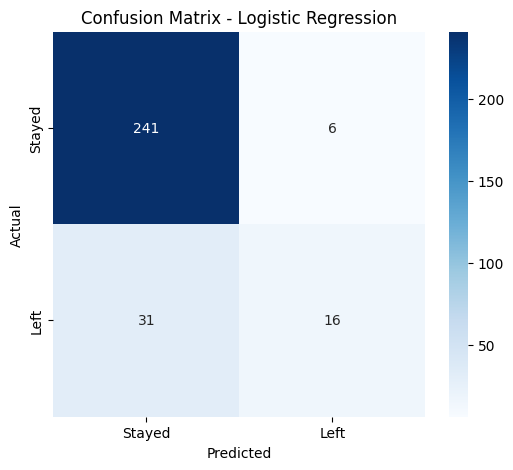

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

log_model = LogisticRegression(random_state=42, max_iter=1000)

log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)

log_accuracy = accuracy_score(y_test, y_pred_log)
log_precision = precision_score(y_test, y_pred_log)
log_recall = recall_score(y_test, y_pred_log)

print(f"Logistic Regression Accuracy: {log_accuracy:.4f}")
print(f"Logistic Regression Precision: {log_precision:.4f}")
print(f"Logistic Regression Recall: {log_recall:.4f}")

conf_matrix_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_log, annot=True, fmt="d", cmap="Blues", xticklabels=["Stayed", "Left"], yticklabels=["Stayed", "Left"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()